# Twisted $H_2$ Chain: The helical ladder

Calculation of the band structure and Bloch states for an infinite-chain of hydrogen molecules with a screw axis in the translationally invariant direction. Calculated using the tight-binding approximation as implemented by the 'kwant' quantum transport software. 

### Goals
1. Calculate band structure and eigenstates for a system with a unit cell of arbitrary size. 
2. Calculate the 'effective band structure' of the supercell system. i.e. unfold the super Brillouin zone band structure into the primitive Brillouin zone.

## Hamiltonian
Kwant performs calculations in the framework of the tight-binding approximation. In this simulation we consider a system defined on a 2D rectangular Bravais lattice $$\begin{equation*}
\Lambda = \big\{ \vec{R} = n_1\vec{a}_1 + n_2\vec{a}_2 \;|\; n_1 \in \mathbb{Z}, n_2 \in (0,1) \big\}
\end{equation*}$$
with primitive lattice vectors
$$\begin{equation*}
\vec{a}_1 = (a, 0) \quad \vec{a}_2 = (0, b)
\end{equation*}$$
The general Hamiltonian for such a system takes the form
$$\begin{equation*}
H = \sum_{\Lambda}t_{n, n^\prime}|n\rangle\langle n^\prime| \quad \quad n = (n_1, n_2)
\end{equation*}$$

This general form includes all hoppings, to simplify the problem, we include only nearest and next-nearest neighbor hoppings. We therefore define... <br>
On-site Hamiltonian $n = n^\prime$: $t_{nn} = u$ <br>
x-direction hopping $n^\prime = (n_1+1, n_2)$: $t_{n, n^\prime} = t_{n^\prime, n}^* = -v$ <br>
y-direction hopping $n^\prime = (n_1, n_2+1)$: $t_{n, n^\prime} = t_{n^\prime, n}^* = -t$ <br>
cross hoppings $n^\prime = (n_1+1, n_2+1)$: $t_{n, n^\prime} = t_{n^\prime, n}^* = -w$ <br>

### Twist angle
Twist angle along the translationally symmetric direction is modeled via scaling the hopping parameters $v,t,w$ according to the magnitude of the distance between sites as
$$\begin{align*}
v \rightarrow v/l_v^2 = v/(0.5a^2(1-\cos(\phi)) + b^2) \\
w \rightarrow w/l_w^2 = w/(0.5a^2(1+\cos(\phi)) + b^2)
\end{align*}$$
A consequence of introducing a twist angle is the need to describe the twisted system using a supercell. With a twist angle of $\phi = 2\pi/N_{\phi}$ between $H_2$ 'layers', the system now has a period of $N_{\phi}a$. Therefore, we need to use a supercell containing $N_{\phi}$ primitive unit cells. 

### Unit cell / Super cell
The standard unit cell of the $H_2$ ladder is a rectangle defined by the primitive lattice vectors $\vec{a}_1$ and $\vec{a}_2$ as defined above. Within the rectangular unit cell a basis of two $H$ atoms completes the crystal structure of the system. 

In this notebook, we consider only supercells which are simple, identical multiples of the primitive unit cell such that the size of the unit cell is scaled by a positive integer in the translationally symmetric direction
$$\begin{equation*}
a \rightarrow A = Na \quad \quad N \in \mathbb{Z}
\end{equation*}$$

In [151]:
# Package imports
import kwant
import numpy as np
import matplotlib.pyplot as plt

## System Parameters Definitions
`a, b`: Lattice constants <br>
`width`: Number of atoms in y-direction <br>
`N_phi`: Number of unit cells to include <br>
`hops`: (u, t, v, w) [defined above] <br>
`phi`: twist angle

In [152]:
# Hamiltonian parameters
a = 1
b = 1
width = 2
N_phi = 2
A = N_phi*a
hops = (5,5,2,1) # u, t, v, w
phi = 0

# Simulation parameters
N_kpts = 101

# Constants
pi = np.pi

## Define kwant Hamiltonian

In [153]:
from math import cos

def hamiltonian(a, b, width, hops, phi, N_phi = 1, finite = False):

    u, t, v, w = hops

    # Define the lattice
    lat_vecs = [(a,0), (0,b)]
    lat = kwant.lattice.general(lat_vecs, norbs=1)

    # Define Hamiltonian
    sys = kwant.Builder()
    if finite:
        # Create a finite sizes system to show structure
        sys[lat.shape((lambda pos: (pos[1] >= 0 and pos[1] < b*width) and (pos[0] >= 0 and pos[0] < N_phi*a)), (0,0))] = u
    else:
        # Create an infinite system for band structure calculations
        sys = kwant.Builder(kwant.TranslationalSymmetry((N_phi*a,0)))
        sys[lat.shape((lambda pos: (pos[1] >= 0 and pos[1] < b*width) and (pos[0] >= 0 and pos[0] < N_phi*a)), (0,0))] = u

    # Intra-layer hoppings
    sys[kwant.builder.HoppingKind((0,1), lat, lat)]  = -t

    # Inter-layer hoppings
    sys[kwant.builder.HoppingKind((1,0), lat, lat)]  = -v*((0.5*a**2)*(1-cos(phi)) + b**2)**(-1)

    # Cross hoppings
    sys[kwant.builder.HoppingKind((1,1), lat, lat)]  = -w*((0.5*a**2)*(1+cos(phi)) + b**2)**(-1)
    sys[kwant.builder.HoppingKind((-1,1), lat, lat)] = -w*((0.5*a**2)*(1+cos(phi)) + b**2)**(-1)

    return sys

## Initialize both unit cell and super cell systems
To compare the two systems, we initialize the same Hamiltonian defined above for a standard unit cell and a supercell. 

In [154]:
# Create the systems for the primitive cell and super cell
pc_sys = hamiltonian(a, b, width, hops, phi)
SC_sys = hamiltonian(a, b, width, hops, phi, N_phi)

# Retrieve positions
pc_pos = np.array([site.pos for site in pc_sys.sites()])
SC_pos = np.array([site.pos for site in SC_sys.sites()])

pc_sys = pc_sys.finalized()
SC_sys = SC_sys.finalized()

## Reciprocal lattice and the Brillouin zone
A fundamental geometric consequence of performing calculations using supercells is the 'folding' of the Brillouin zone. For the simple supercell we consider here, scaling the primitive unit cell by the factor $N_{\phi}$ folds the primitive Brillouin zone (pbz) $N_{\phi}$ times, reducing the size of the super Brillouin zone (SBZ) by a factor $1/N_{\phi}$. 

Here, we construct the unit cell and supercell reciprocal lattices and their respective Brillouin zones to visualize their geometries. 

Primitive cell lattice vectors: 
[[1 0]
 [0 1]]
Primitive cell reciprocal lattice vectors: 
[[-6.28318531  0.        ]
 [ 0.          6.28318531]]


Super cell lattice vectors: 
[[2 0]
 [0 1]]
Super cell reciprocal lattice vectors: 
[[-3.14159265  0.        ]
 [ 0.          6.28318531]]




([<matplotlib.axis.XTick at 0x1a3250970>,
 [Text(-6.283185307179586, 0, '$-2\\pi$'),
  Text(-3.141592653589793, 0, '$-\\pi$'),
  Text(-1.5707963267948966, 0, '$-\\pi/A$'),
  Text(0.0, 0, '$0$'),
  Text(1.5707963267948966, 0, '$\\pi/A$'),
  Text(3.141592653589793, 0, '$\\pi$'),
  Text(6.283185307179586, 0, '$2\\pi$')])

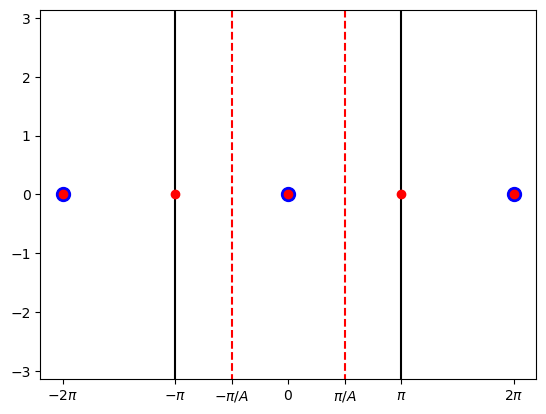

In [155]:
def reciprocal_vecs(lattice_vectors):
    '''Returns the reciprocal lattice vectors for a set of real-space lattice vectors'''
    a1, a2 = lattice_vectors
    R_90 = np.array([[0, -1],[1, 0]])
    V = np.dot(-a1,np.matmul(R_90, a2))
    b1 = (2*np.pi/V)*np.matmul(R_90, a2)
    b2 = (2*np.pi/V)*np.matmul(R_90, a1)
    return np.array([b1, b2])

# Define the primitice cell direct and reciprocal lattice vectors
pc_lat_vecs = np.array([[a, 0], [0, b]])
pc_rec_vecs = reciprocal_vecs(pc_lat_vecs)
print('Primitive cell lattice vectors: \n' + str(pc_lat_vecs))
print('Primitive cell reciprocal lattice vectors: \n' + str(pc_rec_vecs))
print('\n')

# Define the super cell direct and reciprocal lattice vectors
M = np.array([[N_phi, 0], [0, 1]])
SC_lat_vecs = np.matmul(M, pc_lat_vecs)
SC_rec_vecs = reciprocal_vecs(SC_lat_vecs)
print('Super cell lattice vectors: \n' + str(SC_lat_vecs))
print('Super cell reciprocal lattice vectors: \n' + str(SC_rec_vecs))
print('\n')

# Create the reciprocal lattice over an arbitrary range
rec_lat_range = range(-25,25)
g0 = 2*np.pi/a 
G0 = 2*np.pi/A
g = np.array([2*n*np.pi/a for n in rec_lat_range])
G = np.array([2*n*np.pi/A for n in rec_lat_range])

# Plot reciprocal lattice
plt.scatter(g, 50*[0], s=100, color = 'b')
plt.scatter(G, 50*[0], color = 'r')
plt.xlim(-1.1*g0,1.1*g0)
plt.ylim(-0.5*g0,0.5*g0)

# Plot Brillouin zones
plt.vlines(g0/2, -10, 10, color = 'k', zorder = 0)
plt.vlines(-g0/2, -10, 10, color = 'k', zorder = 0)
plt.vlines(G0/2, -10, 10, color = 'r', ls='--')
plt.vlines(-G0/2, -10, 10, color = 'r', ls='--')

# Tick with multiples of pi for clarity
plt.xticks([-2*np.pi, -np.pi, -np.pi/N_phi, 0, np.pi/N_phi, np.pi, 2*np.pi],
           ['$-2\pi$', '$-\pi$', '$-\pi/A$', '$0$', '$\pi/A$','$\pi$', '$2\pi$'])

## Wave vectors in the pbz/SBZ
The folding of wave vectors from the pbz to the SBZ is a process determined completely by the geometry and symmetries of the supercell and it's underlying primitive cell. A wave vector $\vec{k}$ in the pbz is said to fold into a wave vector $\vec{K}$ in the SBZ if there exists a supercell reciprocal lattice vector $\vec{G}$ such that
$$\begin{equation*}
\vec{K} = \vec{k} - \vec{G}
\end{equation*}$$
For our pbz/SBZ geometry we want to identify all wave vectors $\vec{K}$ which correspond to a folded $\vec{k}$. This is done by scanning through each $\vec{k}$ point in the pbz (the array `kpts`) and checking all supercell reciprocal lattice vectors $\vec{G}$ (within the finite, but large set we have defined) to see if the corresponding $\vec{K} = \vec{k} - \vec{G}$ falls within the SBZ we have defined. If the wave vector $\vec{K}$ is in the SBZ, we append that value to an array `Kpts` and the 'folding reciprocal lattice vector' $\vec{G}_i$ to an array `Gi`. Otherwise, we check another $\vec{G}$ until we have exhausted our reciprocal lattice vectors. 

In [156]:
# Define the pbz wave vectors k
# Don't include -pi exactly to avoid double counting
kpts = np.linspace(-np.pi+1e-8, np.pi, N_kpts)

# Calculate super cell K points from the pbz k points
def get_K_from_k(kpts, G_vecs, G0):
    Kpts = []
    Gi   = []
    for k in kpts:
        for G in G_vecs:
            K = k - G
            if np.abs(K) <= 0.5*np.abs(G0):
                Kpts.append(K)
                Gi.append(G)
    return np.array(Kpts), np.array(Gi)

Kpts, G_unfold = get_K_from_k(kpts, G, G0)

## Eigenvalues $\epsilon_n(k)$: the band structure
The band structure is calculated with a call to the `kwant.physics.Bands` object which returns all eigenvalues $\epsilon_n(k)$ for the input wave vector $k$. This function call solves the eigenvalue problem for a single Fourier component of the Schrodinger equation
$$\begin{equation*}
\big[V^{\dagger}e^{ik} + H + Ve^{-ik}\big]|u_{nk}\rangle = \epsilon_n(k)|u_{nk}\rangle
\end{equation*}$$
where $V$ represents the Hamiltonian for hoppings from one unit cell to the next (i.e. the inter-cell hoppings `sys.inter_cell_hoppings`) and $H$ represents the unit cell Hamiltonian (`sys.cell_hamiltonian`). This equation effectively ignores the length scales ($a$ or $A$) of the lattice parameters, we must input them directly by using a momenta $-\pi < ka \le \pi$ (or for the super cell $-\pi < KA \le \pi$). 

Text(0, 0.5, '$\\epsilon(k)$')

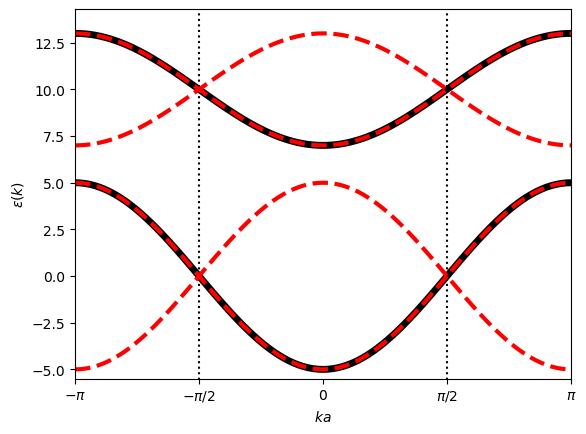

In [163]:
# Create Bands object instance for both cells
pc_bands = kwant.physics.Bands(pc_sys)
SC_bands = kwant.physics.Bands(SC_sys)

# Calculate the band structure E_n(k)
pc_energies = [pc_bands(k*a) for k in kpts]
SC_energies = [SC_bands(K*A) for K in Kpts]

# Plot the energies as a function of momenta, i.e the band structure
fig, band_ax = plt.subplots()
band_ax.plot(kpts, pc_energies, color = 'k', lw = 5)
band_ax.plot(kpts, SC_energies, color = 'r', lw = 3, ls='--', zorder = 2)
band_ax.vlines(kpts[-1]/N_phi, -20, 20, color = 'k', ls = ':', zorder = 0)
band_ax.vlines(kpts[0]/N_phi, -20, 20, color = 'k', ls = ':', zorder = 0)
band_ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
band_ax.set_xlim(-np.pi,np.pi)
band_ax.set_ylim(1.1*np.min(pc_energies), 1.1*np.max(pc_energies))
band_ax.set_xlabel(r'$ka$')
band_ax.set_ylabel(r'$\epsilon(k)$')

## Eigenstates $|u_{nk}\rangle$
Calculating the eigenstates is done similarly: a call to `kwant.physics.Bands`, but returning for each wave vector $k$, the eigenvectors $|u_nk\rangle$ for each eigenvalue $\epsilon_n(k)$ as well. When calculating the unit cell eigenvectors, we extend them to the size of the supercell to be able to calculate quantities e.g. the overlap matrix between SBZ and pbz states $\langle u_{mK}|u_{nk}\rangle$.

In [158]:
N_momenta = len(kpts)

log = open('output.log', 'w')
log.write('Eigenvector output \n\n')

'''Solve the eigenvalue problem for both the primitive cell and the super cell.'''

# Containters for E_n(k) and |u_nk> for both the pc and SC
pc_enk, pc_unk, SC_enk, SC_unk = [], [], [], []

for k in kpts:
    # Solve eigenvalue problem for the unit cell system
    pc_eigvals, pc_eigvecs = pc_bands(k*a, return_eigenvectors = True)
    # eigvecs shape: (Norbs, Nstates)
    # eigvals shape: (Nstates, )

    # N states will be the size of the last dimension of eigvecs
    N_pc_states = np.size(pc_eigvecs, 0)

    # User output
    log.write('pc_eigvecs - k = {} \n'.format(k) + str(pc_eigvecs) + '\n')
    for n in range(N_pc_states):
        log.write('pc_eigvecs - n = {} \n'.format(n) + str(pc_eigvecs[:,n]) + '\n')
    log.write('\n')
    
    # Append to total energy/state arrays
    pc_enk.append(pc_eigvals)
    pc_unk.append(pc_eigvecs)


for K in Kpts:
    # Solve the eigenvalue problem for the super cell system
    SC_eigvals, SC_eigvecs = SC_bands(K*A, return_eigenvectors = True)

    N_SC_states = np.size(SC_eigvecs, 0)

    log.write('SC_eigvecs - k = {} \n'.format(K) + str(SC_eigvecs) + '\n')
    for n in range(N_SC_states):
        log.write('SC_eigvecs - n = {} \n'.format(n) + str(SC_eigvecs[:,n]) + '\n')
    log.write('\n')

    SC_enk.append(SC_eigvals)
    SC_unk.append(SC_eigvecs)

# NumPy array conversion
pc_enk  = np.array(pc_enk)
pc_unk  = np.array(pc_unk)
SC_enk  = np.array(SC_enk)
SC_unk  = np.array(SC_unk)

# Swap unk axis so they are indexed as (N_orbs, N_kpts, N_states)
pc_unk  = np.swapaxes(pc_unk,  0, 1)
SC_unk  = np.swapaxes(SC_unk,  0, 1)

## Visualizing the constructed $u_{nk}(\vec{r}) = \langle \vec{r}|u_{nk}\rangle$

Momentum: 0.0
Eigenenergy 0: -5.00
Eigenstate 0: 
[[-0.70710678+0.j -0.70710678+0.j]]

Eigenenergy 1: 7.00
Eigenstate 1: 
[[-0.70710678+0.j  0.70710678+0.j]]

Momentum: 4.999999969612645e-09
Eigenenergy 0: -5.00
Eigenstate 0: 
[[-0.5+0.00000000e+00j -0.5-1.14481587e-25j]
 [-0.5+2.49999998e-09j -0.5+2.49999998e-09j]]

Eigenenergy 1: 5.00
Eigenstate 1: 
[[ 0.5+0.00000000e+00j  0.5-2.74755808e-24j]
 [-0.5+2.49999998e-09j -0.5+2.49999998e-09j]]

Eigenenergy 2: 7.00
Eigenstate 2: 
[[ 0.5+0.00000000e+00j -0.5+3.15969179e-24j]
 [ 0.5-2.49999998e-09j -0.5+2.49999998e-09j]]

Eigenenergy 3: 13.00
Eigenstate 3: 
[[-0.5+0.00000000e+00j  0.5+5.03718982e-25j]
 [ 0.5-2.49999998e-09j -0.5+2.49999998e-09j]]



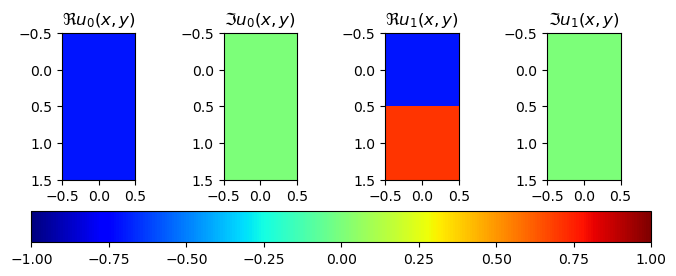

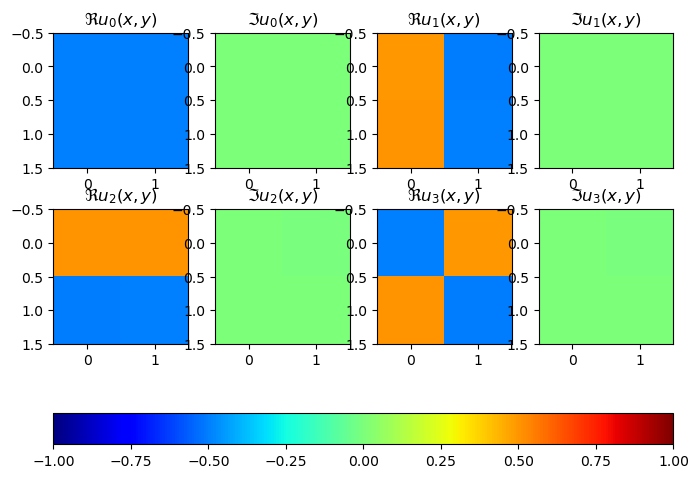

In [159]:
ki = int(N_kpts/2)
# Take a look at the first few eigenvectors for k=0
fig = plt.figure(figsize = (8,6))
ax_pc_unk = []
print('Momentum: {}'.format(np.round(kpts[ki])))
for n in range(N_pc_states):
    # Pick out n-th eigenval/vec
    energy = pc_enk[ki, n]
    state  = np.array(np.array_split(pc_unk[:, ki, n], 1))
    
    # User output
    print('Eigenenergy {}: {:3.2f}'.format(n, energy))
    print('Eigenstate {}: \n'.format(n) + str(state) + '\n')

    # Plot onto real and imaginary axes
    ax_re = fig.add_subplot(2, N_SC_states, 2*n+1)
    ax_im = fig.add_subplot(2, N_SC_states, 2*(n+1))
    ax_re.set_title('$\Re u_{}(x,y)$'.format(n, kpts[ki]))
    ax_im.set_title('$\Im u_{}(x,y)$'.format(n, kpts[ki]))
    plot_unk = ax_re.imshow(np.real(state).transpose(), vmin=-1, vmax = 1, cmap = 'jet')
    plot_unk = ax_im.imshow(np.imag(state).transpose(), vmin=-1, vmax = 1, cmap = 'jet')

    # Add axes to array for colorbar placement
    ax_pc_unk.append(ax_re)
    ax_pc_unk.append(ax_im)

# Create the color bar
fig.colorbar(plot_unk, ax = ax_pc_unk[:], location = 'bottom')

# Take a look at the first few eigenvectors for k=0
fig = plt.figure(figsize = (8,6))
ax_SC_unk = []
print('Momentum: {}'.format(kpts[ki]))
for n in range(N_SC_states):
    # Pick out n-th eigenval/vec
    energy = SC_enk[ki, n]
    state  = np.array(np.array_split(SC_unk[:, ki, n], N_phi))
    
    # User output
    print('Eigenenergy {}: {:3.2f}'.format(n, energy))
    print('Eigenstate {}: \n'.format(n) + str(state) + '\n')

    # Plot onto real and imaginary axes
    ax_re = fig.add_subplot(2, N_SC_states, 2*n+1)
    ax_im = fig.add_subplot(2, N_SC_states, 2*(n+1))
    ax_re.set_title('$\Re u_{}(x,y)$'.format(n, kpts[ki]))
    ax_im.set_title('$\Im u_{}(x,y)$'.format(n, kpts[ki]))
    plot_unk = ax_re.imshow(np.real(state).transpose(), vmin=-1, vmax = 1, cmap = 'jet')
    plot_unk = ax_im.imshow(np.imag(state).transpose(), vmin=-1, vmax = 1, cmap = 'jet')

    # Add axes to array for colorbar placement
    ax_SC_unk.append(ax_re)
    ax_SC_unk.append(ax_im)

# Create the color bar
fig.colorbar(plot_unk, ax = ax_SC_unk[:], location = 'bottom')

plt.show()


## Fourier transform: plane-wave expansion of $|u_{nk}\rangle$

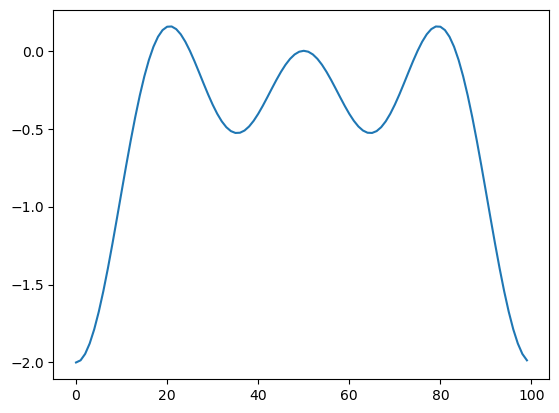

In [183]:
SC_pw = np.fft.fft(SC_unk,n=100,axis=0)
plt.plot(SC_pw[:,0,0])
plt.show()

## Bloch states
Now that we have the $u_{nk}(\vec{r})$ for a single unit cell, we may construct the Bloch states for the infinite system as
$$\begin{equation}
\psi_{nk}(\vec{r}) = e^{i\vec{k}\cdot\vec{r}}u_{nk}(\vec{r})
\end{equation}$$
where we take $k_y = 0$ so we have $\vec{k} = k_x$ and we calculate
$$\begin{equation}
\psi_{nk}(x,y) = e^{ik_x x}u_{nk}(x,y)
\end{equation}$$

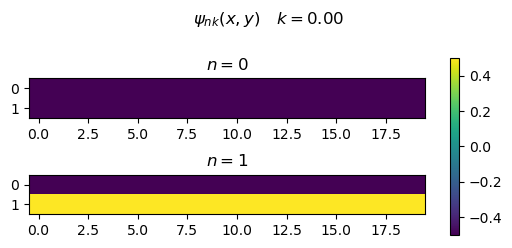

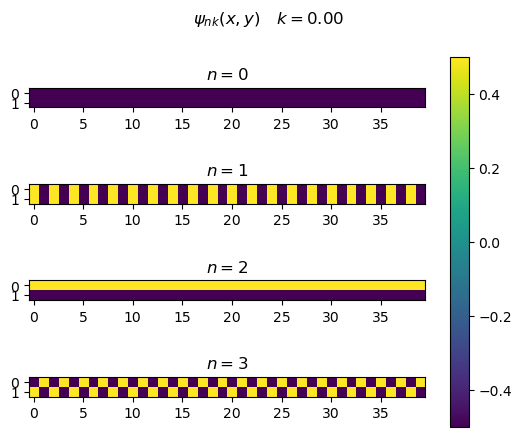

In [160]:
# Extend the u_nk over an arbitrary range in the x-direction
# Split the orbitals up 
N_ext = 20
SC_unk_, pc_unk_ = [], []
for _ in range(N_ext):
    pc_unk_.append(pc_unk)
    for nc in range(N_phi):
        SC_unk_.append(SC_unk[nc*width:(nc+1)*width,:,:])
SC_unk_ = np.array(SC_unk_)
pc_unk_ = np.array(pc_unk_)

# Calculate the Bloch states by modulating the extended u_nk by a plane wave
pc_psi_nk = np.zeros((N_ext, width, N_kpts, N_pc_states), dtype=complex)
SC_psi_nk = np.zeros((N_ext*N_phi, width, N_kpts, N_SC_states), dtype=complex)
for ni in range(N_pc_states):
    for ki, k in enumerate(kpts):
        for xi in range(N_ext):
            pc_psi_nk[xi, :, ki, ni] += np.exp(1j*k*xi)*pc_unk_[xi, :, ki, ni]

for ni in range(N_SC_states):
    for ki, k in enumerate(kpts):
        for xi in range(N_ext*N_phi):
            SC_psi_nk[xi, :, ki, ni] += np.exp(1j*k*xi/N_phi)*SC_unk_[xi, :, ki, ni]

# Plot the Bloch states
ki = int(N_kpts/2)
fig = plt.figure()
ax_pc_psi = []
for n in range(N_pc_states):
    ax = fig.add_subplot(4,1,n+1)

    #ax.set_title('$n = {}, \quad E_{} = {:3.2f}$'.format(n, n, SC_enk[n]))
    plot_psi = ax.imshow(pc_psi_nk[:,:,ki,n].real.transpose(), 
                        vmin=-0.5, vmax = 0.5)
    ax.set_title('$n = {}$'.format(n))
    ax_pc_psi.append(ax)

fig.colorbar(plot_psi, ax = ax_pc_psi[:], location = 'right')
fig.suptitle('$\psi_{nk}(x,y)\quad' + 'k = {:3.2f}$'.format(kpts[ki]))

fig = plt.figure()
ax_SC_psi = []
for n in range(N_SC_states):
    ax = fig.add_subplot(N_SC_states,1,n+1)

    #ax.set_title('$n = {}, \quad E_{} = {:3.2f}$'.format(n, n, SC_enk[n]))
    plot_psi = ax.imshow(SC_psi_nk[:,:,ki,n].real.transpose(), 
                        vmin=-0.5, vmax = 0.5)
    ax.set_title('$n = {}$'.format(n))
    ax_SC_psi.append(ax)

fig.colorbar(plot_psi, ax = ax_SC_psi[:], location = 'right')
fig.suptitle('$\psi_{nk}(x,y)\quad' + 'k = {:3.2f}$'.format(Kpts[ki]))
plt.show()

## Band structure unfolding
Now that we have the band structure and eigenstates calculated, we are now prepared to unfold the supercell band structure into an effective band structure defined over the pbz. The technique we will use is taken from an article by [Popescu/Zunger](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.85.085201). In this method, we project the SBZ states $|Km\rangle = |u_{mK}\rangle$ onto all the pbz states $|kn\rangle = |u_{nk}\rangle$ of a fixed wave vector $k$ and calculating the spectral weight
$$\begin{equation*}
P_{Km}(k) = \sum_n |\langle Km|kn \rangle|^2
\end{equation*}$$
This quantity represents the probability of finding a set of primitive cell $\{|kn\rangle\}$ states contributing to the supercell state $|Km\rangle$, or, equivalently, the amount of Bloch character $k$ preserved in $|Km\rangle$ at the same energy $\epsilon_n = \epsilon_m$. From this quantity, we may then calculate a spectral function
$$\begin{equation*}
A(k, \epsilon) = \sum_m P_{Km}(k) \delta(\epsilon_m - \epsilon)
\end{equation*}$$
which now serves as our desired effective band structure. To approximate the [Dirac delta function](https://mathworld.wolfram.com/DeltaFunction.html) in this expression, we use the definition of it in terms of a limit of a Lorentzian
$$\begin{equation}
\delta(\epsilon_{m} - \epsilon) = \lim_{\eta \rightarrow 0}\frac{1}{\pi}\frac{\eta}{(\epsilon_m - \epsilon)^2 + \eta^2}
\end{equation}$$
and choose a small, finite $\eta$

In [161]:
# Calculate the dot product
P = np.zeros((N_kpts, N_SC_states, N_pc_states), dtype=float)
for ik, _ in enumerate(kpts):
    for m in range(N_SC_states):
        for n in range(N_pc_states):
            P[ik,m,n] += np.abs(np.vdot(SC_unk[:, ik, m], pc_unk_[:, ik, n]))**2

# Sum over the SBZ states, constructing the P_mK(k)
P_mK = np.sum(P, axis = 2)

# ik = 10
# for n in range(N_SC_states):
#     for m in range(N_pc_states):
#         #print(SC_unk[:,ki_SC,n])
#         #print(pc_unk_[:,ki_pc,m])
#         print('P({},{}) = '.format(n,m) + str(np.round(P[ik,n,m], 5)))

# Calculate the spectral function
eta = 0.1
N_epts = 1000
emin = np.min(SC_enk) - 5*eta
emax = np.max(SC_enk) + 5*eta

e = np.linspace(emin, emax, N_epts)

A_ke = np.zeros((N_kpts, N_epts), dtype=float)
for ki in range(N_kpts):
    for ei in range(len(SC_enk[ki, :])):
        em = SC_enk[ki, ei]
        d = (eta/np.pi)/((em - e)**2 + eta**2)
        A_ke[ki] += P_mK[ki, ei]*d


A_ke /= np.max(A_ke)
plt.imshow(np.flip(A_ke).T, vmin=0, vmax=1, aspect='auto')
plt.xlabel('k')
plt.ylabel('$\epsilon(k)$')

ValueError: cannot reshape array of size 40 into shape (4,)